anitaostroumov@gmail.com אניטה אוסטרואומוב  310500160
asaf.ach@gmail.com אסף אחי מרדכי 035892306

# RNN for text classification and text generation
### Dr. Omri Allouche 2018. YData Deep Learning Course

[Open in Google Colab](https://colab.research.google.com/github/omriallouche/deep_learning_course/blob/master/DL_rnn_text_classification_generation.ipynb)

In the first part of this exercise, we’ll continue our attempts to classify text using different network architectures. This time, we’ll try a LSTM. We'll use the Metrolyrics dataset we used in the previous exercise.  

You are encouraged to review the code in [this](https://github.com/prakashpandey9/Text-Classification-Pytorch) repo, that contains implementation of several deep learning architectures for text classification in PyTorch. If you face time limitations, you're welcome to adapt it to your needs instead of writing your own code from scratch.

In the second part of this exercise, you'll unleash the hidden creativity of your computer, by letting it generate Country songs (yeehaw!). You'll train a character-level RNN-based language model, and use it to generate new songs.


### Special Note
Our Deep Learning course was packed with both theory and practice. In a short time, you've got to learn the basics of deep learning theory and get hands-on experience training and using pretrained DL networks, while learning PyTorch.  
Past exercises required a lot of work, and hopefully gave you a sense of the challenges and difficulties one faces when using deep learning in the real world. While the investment you've made in the course so far is enormous, I strongly encourage you to take a stab at this exercise. 

DL networks for NLP are much shallower than those for image classification. It's possible to construct your own networks from scratch, and achieve nice results. While I hope the theoretical foundations of RNNs are clear after our class sessions, getting your hands dirty with their implementation in PyTorch allows you to set breakpoints, watch the dimensions of the different layers and components and get a much better understand of theory, in addition to code that might prove useful later for your own projects. 

I tried to provide references for all parts that walk you through a very similar task (actually, the same task on a different dataset). I expect this exercise to require much less of your time than previous exercises.

The exercise is aimed to help you get better understanding of the concepts. I am not looking for the optimal model performance, and don't look for extensive optimization of hyperparameters. The task we face in this exercise, namely the classification of the song’s genre from its text alone, is quite challenging, and we probably shouldn’t expect great results from our classifier. Don’t let this discourage you - not every task reaches an f1 score of 90%+. 

In fact, some of the reasons I chose this dataset is because it highlights some of the issues we face in machine learning models in the real world. Examples include:
- The classes are highly imbalanced - try to think how this affects the network learning
- Given the small amount of data for some classes, you might actually prefer to remove them from the dataset. How would you decide that?
- NLP tasks often involve preprocessing (lowercasing, tokenization, lemmatization, stopwords removal etc.). The decision on the actual preprocessing pipeline depends on the task, and is often influenced by our believes about the data and exploratory analysis of it. Thinking conciously about these questions helps you be a better data scientist
- Some songs contain no lyrics (for example, they just contain the text "instrumental"). Others include non-English characters. You'll often need to preprocess your data and make decisions as to what your network should actually get as input (think - how should you treat newline characters?)
- While model performance on this dataset are not amazing, we can try to answer interesting follow-up questions - which genres are more similar to each other and are often confused? Do genres become more similar through the years? ...

More issues will probably pop up while you're working on this task. If you face technical difficulties or find a step in the process that takes too long, please let me know. It would also be great if you share with the class code you wrote that speeds up some of the work (for example, a data loader class, a parsed dataset etc.)

## RNN for Text Classification
In this section you'll write a text classifier using LSTM, to determine the genre of a song based on its lyrics.  
The code needed for this section should be very similar to code you've written for the previous exercise, and use the same dataset.  

#### Load the data

In [430]:
import re
import pandas as pd
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [431]:
# Load the data
raw_data = pd.read_csv("380000-lyrics-from-metrolyrics.zip")

In [432]:
# Clean the data
data = raw_data
print(data.shape)
data = data.loc[data["lyrics"].str.len() > 3] # filter for songs with more than 3 words
data = raw_data[raw_data["genre"] != "Not Available"] # remove "Not Available genre"
data = data[data["genre"].notnull()] # remove null genres
print(data.shape)
data

(362237, 6)
(332423, 6)


,index,song,year,artist,genre,lyrics
0,0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."
1,1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see..."
2,2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...
3,3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote..."
4,4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po..."
...,...,...,...,...,...,...
362232,362232,who-am-i-drinking-tonight,2012,edens-edge,Country,"I gotta say\nBoy, after only just a couple of ..."
362233,362233,liar,2012,edens-edge,Country,I helped you find her diamond ring\nYou made m...
362234,362234,last-supper,2012,edens-edge,Country,Look at the couple in the corner booth\nLooks ...
362235,362235,christ-alone-live-in-studio,2012,edens-edge,Country,When I fly off this mortal earth\nAnd I'm meas...


In [433]:
# suffle the data
from sklearn.utils import shuffle

data = shuffle(data)

In [434]:
genres_distribution = data['genre'].value_counts()
genres_distribution

Rock          131377
Pop            49444
Hip-Hop        33965
Metal          28408
Other          23683
Country        17286
Jazz           17147
Electronic     16205
R&B             5935
Indie           5732
Folk            3241
Name: genre, dtype: int64

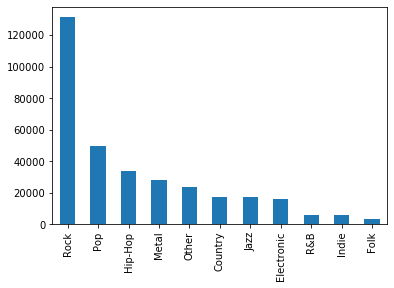

In [435]:
genres_distribution.plot.bar()

In [436]:
data_missing_lyrics = raw_data[raw_data['lyrics'].isnull()]
print(f"Songs with no lyrics is {len(data_missing_lyrics)} / {len(raw_data['lyrics'])} = {len(data_missing_lyrics) / len(raw_data['lyrics'])}")
      
data_instrumental_lyrics = raw_data[raw_data['lyrics'] == "instrumental"]
print(f"Instrumental songs is {len(data_instrumental_lyrics)} / {len(raw_data['lyrics'])} {len(data_instrumental_lyrics) / len(raw_data['lyrics'])}%")

Songs with no lyrics is 95680 / 362237 = 0.264136463144295
Instrumental songs is 80 / 362237 0.00022084988557215303%


In [437]:
data = data[data['lyrics'].notnull()]

In [438]:
data = data[data['lyrics'] != "Not Available"]

In [439]:
from gensim.models import Word2Vec

w2v_model = Word2Vec.load("300features_40minwords_10context.wv.model")

INFO - 10:27:14: 'pattern' package not found; tag filters are not available for English
INFO - 10:27:14: loading Word2Vec object from 300features_40minwords_10context.wv.model
INFO - 10:27:15: loading wv recursively from 300features_40minwords_10context.wv.model.wv.* with mmap=None
INFO - 10:27:15: setting ignored attribute vectors_norm to None
INFO - 10:27:15: loading vocabulary recursively from 300features_40minwords_10context.wv.model.vocabulary.* with mmap=None
INFO - 10:27:15: loading trainables recursively from 300features_40minwords_10context.wv.model.trainables.* with mmap=None
INFO - 10:27:15: setting ignored attribute cum_table to None
INFO - 10:27:15: loaded 300features_40minwords_10context.wv.model


In [440]:
import numpy as np

PAD = "<pad>"
w2v_model.wv["<pad>"] = np.zeros(300,)

### Split the data to train and test

In [441]:
import re
from nltk.corpus import stopwords

def process_document(text, remove_panctuations=True, 
                        remove_stopwords=True, remove_unknown_words=True, fix_length=200):
    
    if remove_panctuations:
      text = re.sub("[^a-zA-Z0-9]"," ", text)
    #
    # Convert words to lower case and split them
    words = text.lower().split()
    #
    # Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w.lower() in stops]  
        
    if remove_unknown_words:
        words = [w for w in words if w in w2v_model.wv]
        
    if len(words) < fix_length:
        words += ([PAD] * (fix_length - len(words)))
    elif len(words) > fix_length:
        words = words[:fix_length]
        
#     processed_document = " ".join(words)
    return words

In [13]:
def tokenizer(text): # create a tokenizer function
    return process_document(text) #[tok.text for tok in spacy_en.tokenizer(process_document(text))]

In [17]:
from sklearn.preprocessing import LabelBinarizer
ohe = LabelBinarizer()
ohe.fit_transform(data['genre'].values)

def one_hot_encoding(label):
    vec = ohe.transform([label])[0]
    return vec



# Import LabelEncoder
from sklearn import preprocessing

# creating labelEncoder
le = preprocessing.LabelEncoder()

# Converting string labels into numbers.
genres_encoded = le.fit_transform(data["genre"])
genres_encoded

array([10, 10,  7, ..., 10, 10, 10])

In [18]:
from torch.utils.data import Dataset, DataLoader, random_split

In [21]:
import torch

class SongsDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, df):
        """
        Args:
            df (pandas.DataFrame): DataFrame object
        """
        self.texts = df['lyrics'].values
        self.labels = df['genre'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.texts[idx]
        text = tokenizer(text)
        text = [w2v_model.wv.vocab[word].index for word in text]
        label = self.labels[idx]
        label = one_hot_encoding(label)

        sample = (torch.tensor(text), torch.tensor(label))

        return sample

In [22]:
dataset = SongsDataset(data[:1000])

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
val_loader = DataLoader(val_data, batch_size=8, shuffle=True)

dataset.__getitem__(99)

(tensor([ 1328,  1797,   301,  4398,  1060,    97,  1172,  4861,  5370, 16835,
          1209,   429,  3530,   989,  5701,  2115,  1029,   147,  1029,   147,
          1029,   147,  1029,   147,   490,  3909,  1165,  2762,  1473,   721,
           194,   564,  4234,  1316,  2355,  4790,  1951,   399,  5940,  6893,
          1029,   147,  1029,   147,  1029,   147,  1029,   147,  1914,   615,
          1199,   222,  1968,    52,  1029,   147,  1029,   147,  1029,   147,
          1029,   147,  1914,   615,  1199,   222,  1968,    52,  1199,   222,
          1914,   615,   212,    52,   135,   120,   964,  1323,  1033,  1522,
            77,  1360,  3985,    81,  4585,  2610,    65,  2610,    50,    65,
            55,    30,   681,  1627,  1202,  1050,   612,    70,   423,   400,
           253,  2812,  2330,    72,  4341,   135,  3608,   181,  7154,   882,
          1827,   825,    52,    65,    70,   440,    77,  1285,   368,   500,
           151,   748, 17993,   619,   612,    70,  

#### Model definition

In [23]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F

class LSTMClassifier(nn.Module):
    def __init__(self, batch_size, output_size, hidden_size, vocab_size, embedding_length, weights, freeze_embeddings=False):
        super(LSTMClassifier, self).__init__()

        """
        Arguments
        ---------
        batch_size : Size of the batch which is same as the batch_size of the data returned by the TorchText BucketIterator
        output_size : 2 = (pos, neg)
        hidden_sie : Size of the hidden_state of the LSTM
        vocab_size : Size of the vocabulary containing unique words
        embedding_length : Embeddding dimension of GloVe word embeddings
        weights : Pre-trained GloVe word_embeddings which we will use to create our word_embedding look-up table 

        """

        self.batch_size = batch_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.embedding_length = embedding_length
        
        self.word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(weights), freeze=freeze_embeddings)
#         self.word_embeddings = nn.Embedding(vocab_size, embedding_length)# Initializing the look-up table.
#         self.word_embeddings.weight = nn.Parameter(weights, requires_grad=False) # Assigning the look-up table to the pre-trained GloVe word embedding.
        self.lstm = nn.LSTM(embedding_length, hidden_size)
        self.dense = nn.Linear(hidden_size, output_size)

    def forward(self, input_sentence, batch_size=None):

        """ 
        Parameters
        ----------
        input_sentence: input_sentence of shape = (batch_size, num_sequences)
        batch_size : default = None. Used only for prediction on a single sentence after training (batch_size = 1)
        
        Returns
        -------
        Output of the linear layer containing logits for positive & negative class which receives its input as the final_hidden_state of the LSTM
        final_output.shape = (batch_size, output_size)
        
        """
        
        ''' Here we will map all the indexes present in the input sequence to the corresponding word vector using our pre-trained word_embedddins.'''
        input = self.word_embeddings(input_sentence) # embedded input of shape = (batch_size, num_sequences,  embedding_length)
        input = input.permute(1, 0, 2) # input.size() = (num_sequences, batch_size, embedding_length)

        if batch_size is None:
            h_0 = torch.zeros(1, self.batch_size, self.hidden_size) # Initial hidden state of the LSTM
            c_0 = torch.zeros(1, self.batch_size, self.hidden_size) # Initial cell state of the LSTM
        else:
            h_0 = torch.zeros(1, batch_size, self.hidden_size)
            c_0 = torch.zeros(1, batch_size, self.hidden_size)
        output, (final_hidden_state, final_cell_state) = self.lstm(input, (h_0, c_0))
        logits = self.dense(final_hidden_state[-1]) # final_hidden_state.size() = (1, batch_size, hidden_size) & final_output.size() = (batch_size, output_size)
    
        return logits

#### Instantiate the model

In [24]:
NUM_CLASSES = 11 # 11 genres of songs
DROPOUT = 0.25
VOCAB_SIZE = len(w2v_model.wv.vocab)
EMBED_DIM = 300
HIDDEN_SIZE=256
BATCH_SIZE=8
weights =  w2v_model.wv.vectors #TEXT.vocab.vectors

model = LSTMClassifier(batch_size=BATCH_SIZE, output_size=NUM_CLASSES, hidden_size=HIDDEN_SIZE, 
                       vocab_size=VOCAB_SIZE, embedding_length=EMBED_DIM, weights=weights)

#### Functions to train and evaluate the model

In [25]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    
    probs = torch.softmax(preds, dim=1)
    winners = probs.argmax(dim=1)
    correct = (winners == y.argmax(dim=1)).float() #convert into float for division 

    acc = correct.sum() / len(correct)
    return acc

def train(model, loader, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for index, batch in enumerate(loader):
        
        # handle case where one of the batches is of size that is smaller than declared batch size
        # todo!!!
        
        optimizer.zero_grad()
        
        predictions = model(batch[0]).squeeze(1)
        
        loss = criterion(predictions, batch[1])
        
        acc = binary_accuracy(predictions, batch[1])
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(loader), epoch_acc / len(loader)

def evaluate(model, loader, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for index, batch in enumerate(loader):

            predictions = model(batch[0]).squeeze(1)
            
            loss = criterion(predictions, batch[1])
            
            acc = binary_accuracy(predictions, batch[1])

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(loader), epoch_acc / len(loader)

import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Training the model

In [26]:
import torch.optim as optim
import time

N_EPOCHS = 10

optimizer = optim.Adam(model.parameters())
criterion = nn.MultiLabelSoftMarginLoss()

best_val_loss = float('inf')

all_train_losses = []
all_val_losses = []
train_accuracy = []
val_accuracy = []

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    all_train_losses.append(train_loss)
    train_accuracy.append(train_acc)

    val_loss, val_acc = evaluate(model, val_loader, criterion)
    all_val_losses.append(val_loss)
    val_accuracy.append(val_acc)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best-model.model')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 27s
	Train Loss: 0.289 | Train Acc: 40.25%
	 Val. Loss: 0.258 |  Val. Acc: 38.00%
Epoch: 02 | Epoch Time: 0m 23s
	Train Loss: 0.244 | Train Acc: 43.75%
	 Val. Loss: 0.258 |  Val. Acc: 38.00%
Epoch: 03 | Epoch Time: 0m 24s
	Train Loss: 0.238 | Train Acc: 44.75%
	 Val. Loss: 0.248 |  Val. Acc: 43.00%
Epoch: 04 | Epoch Time: 0m 24s
	Train Loss: 0.229 | Train Acc: 49.12%
	 Val. Loss: 0.250 |  Val. Acc: 43.00%
Epoch: 05 | Epoch Time: 0m 23s
	Train Loss: 0.224 | Train Acc: 49.75%
	 Val. Loss: 0.247 |  Val. Acc: 41.50%
Epoch: 06 | Epoch Time: 0m 22s
	Train Loss: 0.220 | Train Acc: 50.88%
	 Val. Loss: 0.249 |  Val. Acc: 41.00%
Epoch: 07 | Epoch Time: 0m 22s
	Train Loss: 0.218 | Train Acc: 51.75%
	 Val. Loss: 0.244 |  Val. Acc: 39.50%
Epoch: 08 | Epoch Time: 0m 22s
	Train Loss: 0.215 | Train Acc: 52.12%
	 Val. Loss: 0.249 |  Val. Acc: 43.50%
Epoch: 09 | Epoch Time: 0m 21s
	Train Loss: 0.214 | Train Acc: 52.75%
	 Val. Loss: 0.251 |  Val. Acc: 40.50%
Epoch: 10 | Epoch T

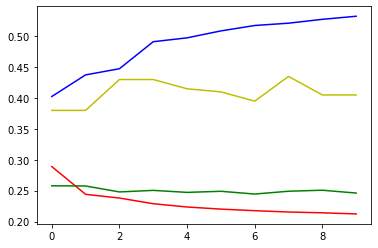

In [27]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_train_losses, 'r')
plt.plot(all_val_losses, 'g')
plt.plot(train_accuracy, 'b')
plt.plot(val_accuracy, 'y')
plt.show()

## RNN for Text Generation
In this section, we'll use an LSTM to generate new songs. You can pick any genre you like, or just use all genres. You can even try to generate songs in the style of a certain artist - remember that the Metrolyrics dataset contains the author of each song. 

For this, we’ll first train a character-based language model. We’ve mostly discussed in class the usage of RNNs to predict the next word given past words, but as we’ve mentioned in class, RNNs can also be used to learn sequences of characters.

First, please go through the [PyTorch tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html) on generating family names. You can download a .py file or a jupyter notebook with the entire code of the tutorial. 

As a reminder of topics we've discussed in class, see Andrej Karpathy's popular blog post ["The Unreasonable Effectiveness of Recurrent Neural Networks"](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). You are also encouraged to view [this](https://gist.github.com/karpathy/d4dee566867f8291f086) vanilla implementation of a character-level RNN, written in numpy with just 100 lines of code, including the forward and backward passes.  

Other tutorials that might prove useful:
1. http://warmspringwinds.github.io/pytorch/rnns/2018/01/27/learning-to-generate-lyrics-and-music-with-recurrent-neural-networks/
1. https://github.com/mcleonard/pytorch-charRNN
1. https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb

### Load the data

In [28]:
# Load the data from csv
import pandas as pd

raw_data = pd.read_csv("380000-lyrics-from-metrolyrics.zip")

In [29]:
# let's see the data: browse through different songe genres:
print(raw_data[['lyrics', 'genre']])

print(raw_data[raw_data['genre'] == 'Pop'][['lyrics', 'genre']])

                                                   lyrics    genre
0       Oh baby, how you doing?\nYou know I'm gonna cu...      Pop
1       playin' everything so easy,\nit's like you see...      Pop
2       If you search\nFor tenderness\nIt isn't hard t...      Pop
3       Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote...      Pop
4       Party the people, the people the party it's po...      Pop
...                                                   ...      ...
362232  I gotta say\nBoy, after only just a couple of ...  Country
362233  I helped you find her diamond ring\nYou made m...  Country
362234  Look at the couple in the corner booth\nLooks ...  Country
362235  When I fly off this mortal earth\nAnd I'm meas...  Country
362236  I heard from a friend of a friend of a friend ...  Country

[362237 rows x 2 columns]
                                                   lyrics genre
0       Oh baby, how you doing?\nYou know I'm gonna cu...   Pop
1       playin' everything so easy,\nit's

In [30]:
len(raw_data.dropna(subset=['genre']))

362237

In [31]:
len(raw_data)

362237

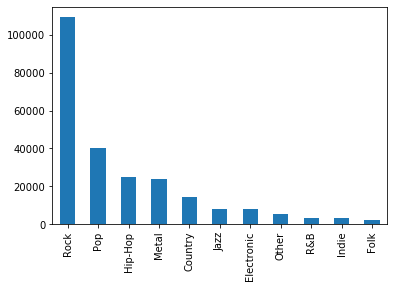

In [32]:
genres_distribution = data['genre'].value_counts()
genres_distribution.plot.bar()

In [33]:
(raw_data.dropna())['lyrics'].apply(lambda lyrics: len(lyrics.split(" ")) if lyrics is not None else 0)


0         384
1         220
2         116
3         436
4         280
         ... 
362232    280
362233    175
362234    213
362235    145
362236    287
Name: lyrics, Length: 266556, dtype: int64

## Word level generation

### Data engineering

In [442]:
from gensim.models import Word2Vec

# load the w2v model
w2v_model = Word2Vec.load("300features_40minwords_10context.wv.model")

INFO - 10:35:49: loading Word2Vec object from 300features_40minwords_10context.wv.model
INFO - 10:35:50: loading wv recursively from 300features_40minwords_10context.wv.model.wv.* with mmap=None
INFO - 10:35:50: setting ignored attribute vectors_norm to None
INFO - 10:35:50: loading vocabulary recursively from 300features_40minwords_10context.wv.model.vocabulary.* with mmap=None
INFO - 10:35:50: loading trainables recursively from 300features_40minwords_10context.wv.model.trainables.* with mmap=None
INFO - 10:35:50: setting ignored attribute cum_table to None
INFO - 10:35:50: loaded 300features_40minwords_10context.wv.model


### Prepare data for trainings

In [443]:
BATCH_SIZE=16
VOCAB_SIZE = len(w2v_model.wv.vocab)

In [444]:
import numpy as np
import re
from nltk.corpus import stopwords

In [445]:
def process_document(text, remove_panctuations=True, 
                        remove_stopwords=True, remove_unknown_words=True, fix_length=200):
    
    if remove_panctuations:
      text = re.sub("[^a-zA-Z0-9]"," ", text)
    #
    # Convert words to lower case and split them
    words = text.lower().split()
    #
    # Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w.lower() in stops]  
        
    if remove_unknown_words:
        words = [w for w in words if w in w2v_model.wv]
        
    if len(words) < fix_length:
        words += ([PAD] * (fix_length - len(words)))
    elif len(words) > fix_length:
        words = words[:fix_length]
        
#     processed_document = " ".join(words)
    return words

def tokenizer(text, **kwargs): # create a tokenizer function
    return process_document(text, **kwargs) #[tok.text for tok in spacy_en.tokenizer(process_document(text))]

In [446]:
from torch.utils.data import Dataset, DataLoader, random_split

class SongsGenerationDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, df, batch_size, vocab_size):
        """
        Args:
            df (pandas.DataFrame): DataFrame object
        """
        self.vocab_size = vocab_size
        
        lyrics = df['lyrics'].values
        lyrics = [tokenizer(text, fix_length=-1) for text in lyrics]
        lyrics = [word for words in lyrics for word in words] # flatten list
        # Next step, we will convert word tokens into integer indices. 
        # These will be the input to the network. And because we will train a mini-batch each iteration, 
        # we should be able to split the data into batches evenly. 
        # We can assure that by chopping out the last uneven batch
        lyrics = [w2v_model.wv.vocab[word].index for word in lyrics]
        batches_number = (int)(len(lyrics) / batch_size)
        lyrics = lyrics[:(batch_size * batches_number)]
        print(len(lyrics))
        print(batches_number)
        print(batch_size)
        
        self.words_in = lyrics
        self.words_out = np.zeros_like(self.words_in)
        self.words_out[:-1] = self.words_in[1:]
        self.words_out[-1] = self.words_in[0]

    def __len__(self):
        return len(self.words_in)

    def __getitem__(self, idx):
        text = self.words_in[idx]
#         label = np.zeros(self.vocab_size)
#         label[self.words_out[idx]] = 1
        label = self.words_out[idx]

        sample = (torch.tensor(text), torch.tensor(label))

        return sample

In [447]:
dataset = SongsGenerationDataset(data[data["genre"] == "Country"][:1000], BATCH_SIZE, VOCAB_SIZE)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

87232
5452
16


In [448]:
dataset.__getitem__(1)

(tensor(304), tensor(525))

### Model definition

In [449]:
class LSTM2(nn.Module):
    def __init__(self, n_vocab, embedding_size, hidden_size, weights, batch_size, freeze_embeddings=True):
        super(LSTM2, self).__init__()
    
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.num_layers = 1
        
        if weights is not None:
            self.word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(weights), freeze=freeze_embeddings)
        else:
            self.word_embeddings = nn.Embedding(n_vocab, embedding_size)
            
        self.lstm = nn.LSTM(input_size=embedding_size, hidden_size=hidden_size, num_layers=self.num_layers)
    
        self.dense = nn.Linear(hidden_size, n_vocab)
        
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x, prev_state):
        embed = self.word_embeddings(x)
        output, state = self.lstm(embed, prev_state)
        output = self.dense(output)
        output = self.softmax(output)
        return output, state
    
    def init_hidden(self):
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_size),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_size))

In [450]:
# instantiate a model
VOCAB_SIZE = len(w2v_model.wv.vocab)
EMBED_DIM = 300
HIDDEN_SIZE =32
weights =  w2v_model.wv.vectors #TEXT.vocab.vectors

model = LSTM2(n_vocab=VOCAB_SIZE, embedding_size=EMBED_DIM, hidden_size=HIDDEN_SIZE, batch_size=BATCH_SIZE, weights=weights)

### Functions to train and evaluate

In [451]:
def clip_gradient(model, clip_value):
    params = list(filter(lambda p: p.grad is not None, model.parameters()))
    for p in params:
        p.grad.data.clamp_(-clip_value, clip_value)
        
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    
    winners = preds.argmax(dim=1)
    correct = (winners == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

def train(model, loader, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    state_h, state_c = model.init_hidden()
    
    for index, (x, y) in enumerate(loader):
        x = x.unsqueeze(0)
        y = torch.autograd.Variable(y).long()
        
        if x.shape[1] != BATCH_SIZE:
            print("x.shape", x.shape)
            continue
        else:
            optimizer.zero_grad()
        
            predictions, (state_h, state_c) = model(x, (state_h, state_c))
            predictions = torch.squeeze(predictions, 0)
        
            loss = criterion(predictions, y)
            acc = binary_accuracy(predictions, y)
        
            loss.backward(retain_graph=True)
            optimizer.step()
        
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(loader), epoch_acc / len(loader)

def evaluate(model, loader, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    state_h, state_c = model.init_hidden()
    
    with torch.no_grad():
        
        for index, (x, y) in enumerate(loader):
            x = x.unsqueeze(0)
            
            if x.shape[1] != BATCH_SIZE:
                print("x.shape", x.shape)
                continue
                
            predictions, (state_h, state_c) = model(x, (state_h, state_c))
            predictions = torch.squeeze(predictions, 0)
            
            loss = criterion(predictions, y)
            acc = binary_accuracy(predictions, y)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(loader), epoch_acc / len(loader)

### Train the network

In [ ]:
import torch.optim as optim
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

N_EPOCHS = 5

optimizer = optim.Adam(model.parameters())
criterion = nn.NLLLoss()

best_val_loss = float('inf')

all_train_losses = []
all_val_losses = []
train_accuracy = []
val_accuracy = []

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    all_train_losses.append(train_loss)
    train_accuracy.append(train_acc)

    val_loss, val_acc = evaluate(model, val_loader, criterion)
    all_val_losses.append(val_loss)
    val_accuracy.append(val_acc)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'lstm-gen-best-model.model')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%')

In [170]:
!ls

300features_40minwords_10context.wv.model
380000-lyrics-from-metrolyrics.zip
DL_rnn_text_classification_generation.ipynb
DL_word_embedding_assignment.ipynb
README.md
best-model.model
best-model.pt
cnn.py
environment.yml
lstm-gen-best-model.model
lstm-gen-best-model.pt
project-tv-script-generation
test.csv
train.csv
val.csv


### Inference

In [87]:
def predict(w, model, length, top_k=5):
    model.eval()
    words = [w]
    state_h, state_c = (torch.zeros(1, 1, 32), torch.zeros(1, 1, 32))
    
    for _ in range(length):
        x = torch.tensor([w2v_model.wv.vocab[w].index])
        x = x.unsqueeze(0)
        output, (state_h, state_c) = model(x, (state_h, state_c))
    
        _, top_index = torch.topk(output[0], k=top_k)
        choices = top_index.tolist()
        choice = np.random.choice(choices[0])
        w = w2v_model.wv.index2word[choice]
        words.append(w) #w2v_model.wv.vocab[choice])

    print(' '.join(words))

In [88]:
predict('dog', model, 50)

dog i the and i the i and and the to i i and and i the the you to you i to and to to the the you you you to you and the and to you i to i and you and to and and the the i the


# Char level generator

### Prepare data for trainings

In [361]:
import os
import unicodedata
import string

all_letters = string.ascii_letters + " \n" #" .,;'-\n"
n_letters = len(all_letters) + 1 # Plus EOSong marker
print(n_letters)

55


In [362]:
all_letters[len(all_letters) - 1]

'\n'

In [363]:
def unicodeToAscii(s):
    """
    Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
    """
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def readLyrics(lyrics):
    return unicodeToAscii(lyrics)

genre_lyrics = {}
all_genres = []

for _, song in data[data["genre"] == "Country"][:1000].iterrows():
    genre = song["genre"]
    all_genres.append(genre)
    lyrics = readLyrics(song["lyrics"])
    genre_lyrics[genre] = lyrics

n_genres = len(all_genres)

### The model

In [364]:
import torch
import torch.nn as nn


class CharLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(CharLSTM, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers)
            
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        batch_size = input.size(0)
        encoded = self.encoder(input)
        output, hidden = self.lstm(encoded, hidden)
        output = self.decoder(output)
        return output, hidden

    def init_hidden(self, batch_size):
        return (torch.zeros(self.n_layers, batch_size, self.hidden_size),
                torch.zeros(self.n_layers, batch_size, self.hidden_size))



### Train

#### Prepare for training

In [365]:
# One-hot vector for category
def genre_tensor(genre):
    idx = all_genres.index(genre)
    tensor = torch.zeros(1, n_genres)
    tensor[0][idx] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def input_tensor(lyrics):
    tensor = torch.zeros([len(lyrics), 1, n_letters], dtype=torch.long)
    for idx in range(len(lyrics)):
        letter = lyrics[idx]
        tensor[idx][0][all_letters.find(letter)] = 1
    print(tensor)
    return tensor

# LongTensor of second letter to end (EOS) for target
def target_tensor(lyrics):
    letter_indexes = [all_letters.find(lyrics[idx]) for idx in range(1, len(lyrics))] # begin from index 1
    letter_indexes.append(n_letters - 1) # EOSong
    return torch.LongTensor(letter_indexes)

In [366]:
import random

# Random item from a list
def random_choice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def random_training_pair():
    genre = random_choice(all_genres)
    lyrics = random_choice(genre_lyrics[genre])
    return genre, lyrics

In [367]:
def random_training_example():
    genre, lyrics = random_training_pair()
    input_genre_tensor = genre_tensor(genre)
    input_lyrics_tensor = input_tensor(lyrics)
    target_lyrics_tensor = target_tensor(lyrics)
    return genre_tensor, input_lyrics_tensor, target_lyrics_tensor

In [368]:
str = 'i love banana\n'
print([all_letters.find(str[idx]) for idx in range(0, len(str))] )
print([all_letters.find(str[idx]) for idx in range(1, len(str))] + [n_letters - 1] )

[8, 52, 11, 14, 21, 4, 52, 1, 0, 13, 0, 13, 0, 53]
[52, 11, 14, 21, 4, 52, 1, 0, 13, 0, 13, 0, 53, 54]


In [369]:
import re
from torch.utils.data import Dataset, DataLoader, random_split

class SongsCharactersDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, songs, batch_size):
        """
        Args:
            songs (pandas.DataFrame): DataFrame object
        """
        self.input = []
        self.target = []
        
        for lyrics in songs['lyrics']:
            lyrics = lyrics.lower().strip()
            lyrics = re.sub("[^a-zA-Z\s\n]"," ", lyrics)
            self.input += [all_letters.find(lyrics[idx]) for idx in range(0, len(lyrics))] 
            self.target += [all_letters.find(lyrics[idx]) for idx in range(1, len(lyrics))] # begin from index 1
            self.target += [n_letters - 1] # EOSong
            
        batches_number = (int)(len(self.input) / batch_size)
        limit = (batch_size * batches_number)
        self.input = self.input[:limit]
        self.target = self.target[:limit]

    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        in_c = self.input[idx]
        out_c = self.target[idx]
        item = (torch.tensor(in_c), torch.tensor(out_c))
        return item

#### Training the network

In [420]:
def clip_gradient(model, clip_value):
    params = list(filter(lambda p: p.grad is not None, model.parameters()))
    for p in params:
        p.grad.data.clamp_(-clip_value, clip_value)
        
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    
    winners = preds.argmax(dim=1)
    correct = (winners == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

def train(model, loader, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    state_h, state_c = model.init_hidden(BATCH_SIZE)
    
    for index, (x, y) in enumerate(loader):
        x = x.unsqueeze(0)
        y = torch.autograd.Variable(y).long()
        
        if x.shape[1] != BATCH_SIZE:
            continue
        else:
            optimizer.zero_grad()
            predictions, (state_h, state_c) = model(x, (state_h, state_c))
            predictions = torch.squeeze(predictions, 0)
            
            loss = criterion(predictions, y)
            acc = binary_accuracy(predictions, y)
        
            loss.backward(retain_graph=True)
            optimizer.step()
        
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(loader), epoch_acc / len(loader)

def evaluate(model, loader, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    state_h, state_c = model.init_hidden(BATCH_SIZE)
    
    with torch.no_grad():
        
        for index, (x, y) in enumerate(loader):
            x = x.unsqueeze(0)
            
            if x.shape[1] != BATCH_SIZE:
                continue
                
            predictions, (state_h, state_c) = model(x, (state_h, state_c))
            predictions = torch.squeeze(predictions, 0)
            
            loss = criterion(predictions, y)
            acc = binary_accuracy(predictions, y)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(loader), epoch_acc / len(loader)

### Train

In [421]:
BATCH_SIZE = 32

model = CharLSTM(input_size=n_letters, hidden_size=128, output_size=n_letters)

In [422]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [423]:
dataset = SongsCharactersDataset(data[data["genre"] == "Country"][:10], BATCH_SIZE)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

In [424]:
dataset.__getitem__(98)

(tensor(52), tensor(2))

In [425]:
import torch.optim as optim
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

N_EPOCHS = 5

optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

best_val_loss = float('inf')

all_train_losses = []
all_val_losses = []
train_accuracy = []
val_accuracy = []

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    all_train_losses.append(train_loss)
    train_accuracy.append(train_acc)

    val_loss, val_acc = evaluate(model, val_loader, criterion)
    all_val_losses.append(val_loss)
    val_accuracy.append(val_acc)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'lstm-gen-best-model.model')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 15s
	Train Loss: 2.710 | Train Acc: 22.95%
	 Val. Loss: 2.449 |  Val. Acc: 25.87%
Epoch: 02 | Epoch Time: 0m 15s
	Train Loss: 2.415 | Train Acc: 25.64%
	 Val. Loss: 2.384 |  Val. Acc: 25.75%
Epoch: 03 | Epoch Time: 0m 15s
	Train Loss: 2.378 | Train Acc: 26.02%
	 Val. Loss: 2.373 |  Val. Acc: 25.93%
Epoch: 04 | Epoch Time: 0m 15s
	Train Loss: 2.358 | Train Acc: 26.06%
	 Val. Loss: 2.358 |  Val. Acc: 23.84%
Epoch: 05 | Epoch Time: 0m 15s
	Train Loss: 2.349 | Train Acc: 25.73%
	 Val. Loss: 2.369 |  Val. Acc: 25.52%


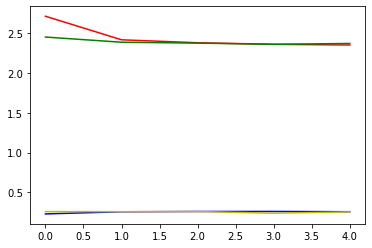

In [426]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_train_losses, 'r')
plt.plot(all_val_losses, 'g')
plt.plot(train_accuracy, 'b')
plt.plot(val_accuracy, 'y')
plt.show()

### Sampling

In [427]:
max_length = 20

# Sample from a category and starting letter
def sample(start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        x = torch.tensor([all_letters.find(start_letter)])
        x = x.unsqueeze(0)
        print(x)
        hidden = model.init_hidden(BATCH_SIZE)

        output_name = start_letter

        for i in range(max_length):
            output, hidden = model([x], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = input_tensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(start_letter))

In [428]:
import numpy as np

def predict(l, model, length, top_k=5):
    model.eval()
    text = [l]
    state_h, state_c = (torch.zeros(1, 1, 128), torch.zeros(1, 1, 128))
    
    for _ in range(length):
        x = torch.tensor([all_letters.find(l)])
        x = x.unsqueeze(0)
        output, (state_h, state_c) = model(x, (state_h, state_c))
    
        _, top_index = torch.topk(output[0], k=top_k)
        choices = top_index.tolist()
        choice = np.random.choice(choices[0])
        l = all_letters[choice]
        text.append(l) #w2v_model.wv.vocab[choice])

    print(' '.join(text))

In [429]:
predict('l', model, 100)

l i s 
 t 
 i s s t h   i t o n g 
 a t 
 w   w o n d s 
 a n e t i s o n d   i   w a r e t   i n   i   s 
 w e a t o n d e s 
 o r   a r i n g   i n o u t   w   i f   s o r   t h o r   t   w   s   a t


### Final Tips
As a final tip, I do encourage you to do most of the work first on your local machine. They say that Data Scientists spend 80% of their time cleaning the data and preparing it for training (and 20% complaining about cleaning the data and preparing it). Handling these parts on your local machine usually mean you will spend less time complaining. You can switch to the cloud once your code runs and your pipeline is in place, for the actual training using a GPU.  

I also encourage you to use a small subset of the dataset first, so things run smoothly. The Metrolyrics dataset contains over 300k songs. You can start with a much much smaller set (even 3,000 songs) and try to train a network based on it. Once everything runs properly, add more data. 

Good luck!  
Omri